In [ ]:
!pip install tensorflow-datasets tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from datetime import datetime
from dateutil.relativedelta import relativedelta as rd

In [ ]:
import tensorflow as tf

# List all physical devices
print("Physical devices:")
print(tf.config.list_physical_devices())

# List all logical devices
print("\nLogical devices:")
print(tf.config.list_logical_devices())

# Attempt to set logical devices for TPU first
tpu_devices = tf.config.list_physical_devices('TPU')
if tpu_devices:
    tf.config.set_visible_devices(tpu_devices[0], 'TPU')
    print("\nTensorFlow configured to use TPU.")
# If no TPU, attempt to set logical devices for GPU
elif tf.config.list_physical_devices('GPU'):
    gpu_devices = tf.config.list_physical_devices('GPU')
    tf.config.set_visible_devices(gpu_devices[0], 'GPU')
    print("\nTensorFlow configured to use GPU.")
# If no TPU or GPU, set logical devices for CPU
else:
    cpu_devices = tf.config.list_physical_devices('CPU')
    if cpu_devices:
        tf.config.set_visible_devices(cpu_devices[0], 'CPU')
        print("\nTensorFlow configured to use CPU.")
    else:
        print("\nNo CPU, GPU, or TPU found to configure.")

Physical devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Logical devices:
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

TensorFlow configured to use GPU.


In [ ]:
ini = datetime.now()

#### Carga y preparación de datos

In [ ]:
bld = tfds.builder('mnist')
bld.download_and_prepare()
ds = bld.as_dataset(shuffle_files=False)
dstro = ds['train']
dsteo = ds['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.8Z6WRV_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.8Z6WRV_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
TAM_BUFF = 10000
TAM_LOTE = 64
NUM_EP = 5

In [ ]:
dstro

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
dstr = dstro.map(lambda item:(tf.cast(item['image'],tf.float32)/255.0,tf.cast(item['label'],tf.int32)))
dste = dsteo.map(lambda item:(tf.cast(item['image'],tf.float32)/255.0,tf.cast(item['label'],tf.int32)))

In [ ]:
type(dstr)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
tf.random.set_seed(0)
dstr = dstr.shuffle(buffer_size=TAM_BUFF,reshuffle_each_iteration=False)
dsva = dstr.take(10000).batch(TAM_LOTE)
dstr = dstr.skip(10000).batch(TAM_LOTE)

#### Construcción de la CNN

In [ ]:
"""
Arquitectura
28x28x1-->Conv(5x5x32)-->28x28x32-->Pooling(2x2)-->14x14x32-->
Conv(5x5x64)-->14x14x64-->Pooling(2x2)-->7x7x64-->Flat-->1024-->
FC1-->dropout(0.5)-->FC2-->10
"""

cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(5,5),
                               strides=(1,1),
                               padding='same',
                               data_format='channels_last',
                               name='conv1',
                               activation='relu'
                              ))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                  name='pool1'
                                 ))

cnn.add(tf.keras.layers.Conv2D(filters=64,
                               kernel_size=(5,5),
                               strides=(1,1),
                               padding='same',
                               data_format='channels_last',
                               name='conv2',
                               activation='relu'
                              ))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                  name='pool2'
                                 ))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1024,
                              name='fc1',
                              activation='relu'
                             ))

cnn.add(tf.keras.layers.Dropout(rate=0.5
                               ))

cnn.add(tf.keras.layers.Dense(units=10,
                              name='fc2',
                              activation='softmax'
                             ))

In [ ]:
tf.random.set_seed(0)
cnn.build(input_shape=(None,28,28,1))

In [ ]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,274,634 (12.49 MB)

 Trainable params: 3,274,634 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento del Modelo

In [ ]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
           )

In [ ]:
historia = cnn.fit(dstr,
                   epochs=NUM_EP,
                   validation_data=dsva,
                   shuffle=True)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.8948 - loss: 0.3215 - val_accuracy: 0.9859 - val_loss: 0.0462
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9850 - loss: 0.0473 - val_accuracy: 0.9879 - val_loss: 0.0427
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9895 - loss: 0.0321 - val_accuracy: 0.9899 - val_loss: 0.0364
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9920 - loss: 0.0251 - val_accuracy: 0.9905 - val_loss: 0.0372
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9938 - loss: 0.0196 - val_accuracy: 0.9898 - val_loss: 0.0394


#### Resultados

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

hist = historia.history
x_arr = np.arange(len(hist['loss']))+1

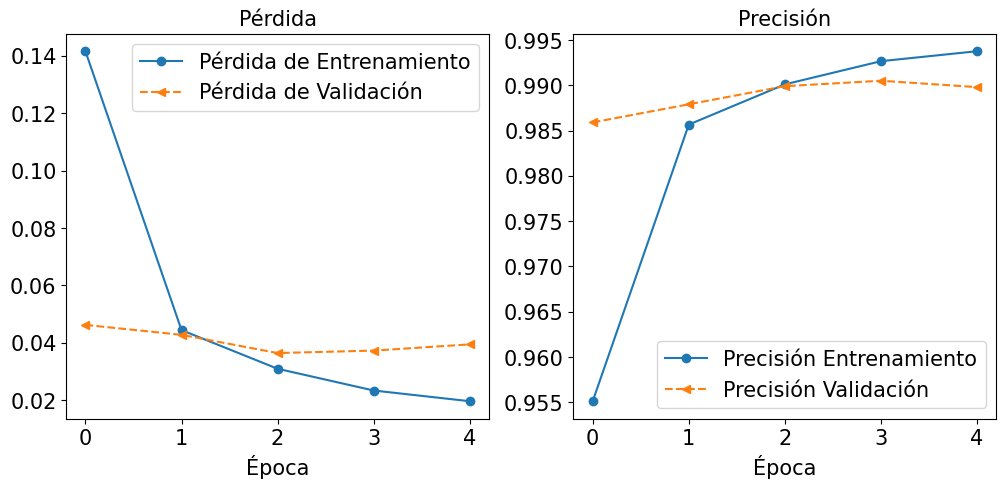

In [ ]:

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_accuracy'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

In [ ]:
resultados_prueba = cnn.evaluate(dste.batch(20))
print('Precisión Prueba %.4f'%resultados_prueba[1])

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9907 - loss: 0.0277
Precisión Prueba 0.9896


tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


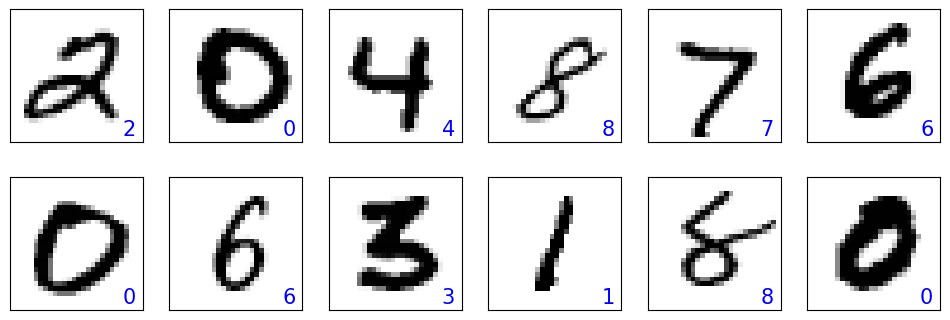

In [ ]:
lote_prueba = next(iter(dste.batch(12)))
pred = cnn(lote_prueba[0])

pred = tf.argmax(pred,axis=1)
print(pred)
fig = plt.figure(figsize=(12,4))
for i in range(12):
    ax = fig.add_subplot(2,6,i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = lote_prueba[0][i,:,:,0]
    ax.imshow(img,cmap='gray_r')
    ax.text (0.9,0.1,'{}'.format(pred[i]),
             size=15,
             color='blue',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)
plt.show()

In [ ]:
rd(datetime.now(),ini)

relativedelta(minutes=+1, seconds=+32, microseconds=+566149)